# Momentum strategy backtest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf

Let's first construct a momentum strategy based on the direction of the sign of the previous return: if the previous return was negative, then we sell the asset, and if it was positive, then we buy the asset. 

In [2]:
start = '2020-01-01'
end = '2025-05-01'

btc = yf.download(tickers='BTC-USD', start=start, end=end)
btc.columns = ['close', 'high', 'low', 'open', 'volumne']
print(btc.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

                  close         high          low         open      volumne
Date                                                                       
2020-01-01  7200.174316  7254.330566  7174.944336  7194.892090  18565664997
2020-01-02  6985.470215  7212.155273  6935.270020  7202.551270  20802083465
2020-01-03  7344.884277  7413.715332  6914.996094  6984.428711  28111481032
2020-01-04  7410.656738  7427.385742  7309.514160  7345.375488  18444271275
2020-01-05  7411.317383  7544.497070  7400.535645  7410.451660  19725074095


In [3]:
# set up the dataset
df = pd.DataFrame(btc['close'].copy())

# compute the log returns
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
print(df.head())

                  close  log_returns
Date                                
2020-01-01  7200.174316          NaN
2020-01-02  6985.470215    -0.030273
2020-01-03  7344.884277     0.050172
2020-01-04  7410.656738     0.008915
2020-01-05  7411.317383     0.000089


In [4]:
# create the positions
df['position'] = np.sign(df['log_returns'])

# compute the strategy returns
df['strategy'] = df['position'].shift(1)*df['log_returns']
print(df.tail())

                   close  log_returns  position  strategy
Date                                                     
2025-04-26  94646.929688    -0.000777      -1.0 -0.000777
2025-04-27  93754.843750    -0.009470      -1.0  0.009470
2025-04-28  94978.750000     0.012970       1.0 -0.012970
2025-04-29  94284.789062    -0.007333      -1.0 -0.007333
2025-04-30  94207.312500    -0.000822      -1.0  0.000822


In [5]:
df[['log_returns', 'strategy']].sum().apply(np.exp)

log_returns    13.084032
strategy        0.192223
dtype: float64

/var/folders/9z/mvzm9dhd5c3dzy6mdkxzhf_c0000gn/T/ipykernel_14315/3852675233.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


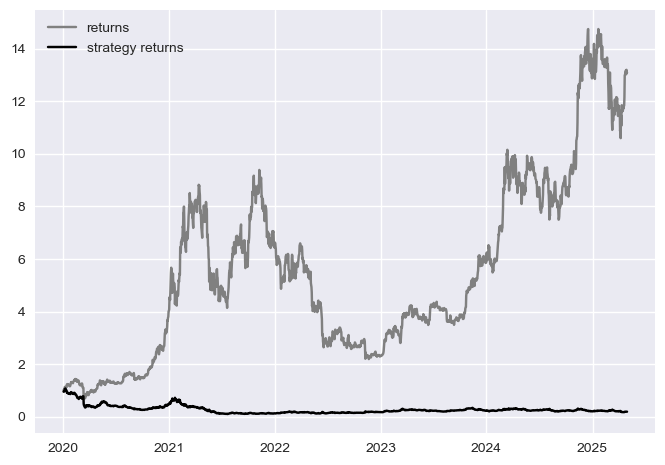

In [6]:
# let's plot the evolution of the returns
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 1)
ax.plot(df['log_returns'].cumsum().apply(np.exp), label='returns', c='gray')
ax.plot(df['strategy'].cumsum().apply(np.exp), label='strategy returns', c='black')
ax.legend()

We can see that this perform poorly compared to the returns of the buy-and-hold. But with more information, we could have better results. We can take the sign of the average of the last 3 returns. 

In [7]:
# compute the position orders and the strategy returns
df['position_3last'] = np.sign(df['log_returns'].rolling(3).mean())
df['strategy_3last'] = df['position_3last'].shift(1) * df['log_returns']
print(df.tail())

                   close  log_returns  position  strategy  position_3last  \
Date                                                                        
2025-04-26  94646.929688    -0.000777      -1.0 -0.000777             1.0   
2025-04-27  93754.843750    -0.009470      -1.0  0.009470            -1.0   
2025-04-28  94978.750000     0.012970       1.0 -0.012970             1.0   
2025-04-29  94284.789062    -0.007333      -1.0 -0.007333            -1.0   
2025-04-30  94207.312500    -0.000822      -1.0  0.000822             1.0   

            strategy_3last  
Date                        
2025-04-26       -0.000777  
2025-04-27       -0.009470  
2025-04-28       -0.012970  
2025-04-29       -0.007333  
2025-04-30        0.000822  


In [8]:
df[['log_returns', 'strategy_3last']].sum().apply(np.exp)

log_returns       13.084032
strategy_3last     4.763702
dtype: float64

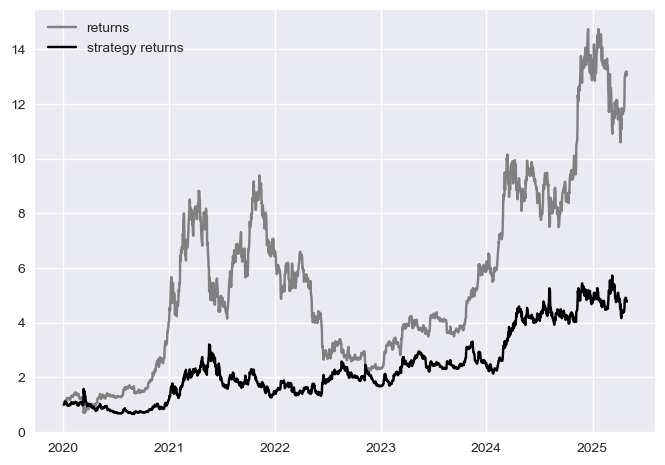

In [9]:
# let's plot the evolution of the returns
fig, ax = plt.subplots(1, 1)
ax.plot(df['log_returns'].cumsum().apply(np.exp), label='returns', c='gray')
ax.plot(df['strategy_3last'].cumsum().apply(np.exp), label='strategy returns', c='black')
ax.legend()

In [ ]:
# find how much trades we execute
trades = (df['position_3last'].diff().fillna(0) != 0).astype(int)
print(trades.sum())

580
